
  ****READING THE DATA


In [ ]:
import numpy as np 
import pandas as pd 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score,roc_curve
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import RandomizedSearchCV 

In [84]:
x = r"C:\Users\zaxak\Desktop\Train.csv"
df = pd.read_csv(x)
df.head()

,ID,Warehouse_block,Mode_of_Shipment,Customer_care_calls,Customer_rating,Cost_of_the_Product,Prior_purchases,Product_importance,Gender,Discount_offered,Weight_in_gms,Reached.on.Time_Y.N
0,1,D,Flight,4,2,177,3,low,F,44,1233,1
1,2,F,Flight,4,5,216,2,low,M,59,3088,1
2,3,A,Flight,2,2,183,4,low,M,48,3374,1
3,4,B,Flight,3,3,176,4,medium,M,10,1177,1
4,5,C,Flight,2,2,184,3,medium,F,46,2484,1


>DATA Preparation





FEATURE ENGINEERING

In [85]:
# Create a boolean mask for categorical columns
categorical_mask = (df.dtypes == 'object')

# Get list of categorical column names
categorical_columns = df.columns[categorical_mask].tolist()

# Print the head of the categorical columns
print(df[categorical_columns].head())

# Create LabelEncoder object: le
le = LabelEncoder()
# Apply LabelEncoder to categorical columns
df[categorical_columns] = df[categorical_columns].apply(lambda x: le.fit_transform(x))

# Print the head of the LabelEncoded categorical columns
print(df[categorical_columns].head())


  Warehouse_block Mode_of_Shipment Product_importance Gender
0               D           Flight                low      F
1               F           Flight                low      M
2               A           Flight                low      M
3               B           Flight             medium      M
4               C           Flight             medium      F
   Warehouse_block  Mode_of_Shipment  Product_importance  Gender
0                3                 0                   1       0
1                4                 0                   1       1
2                0                 0                   1       1
3                1                 0                   2       1
4                2                 0                   2       0


In [86]:
# Feature 1: Discount as a Ratio of Product Cost
df['Discount_as_Ratio'] = df['Discount_offered'] / df['Cost_of_the_Product']


# Feature 2: Product Value Density (Cost per Gram)
# Uses a small value in the denominator to prevent division by zero, though weight is unlikely to be 0.
df['Value_Density'] = df['Cost_of_the_Product'] / (df['Weight_in_gms'] + 1e-6)



cols_to_keep = [ 
     'Discount_offered', 'Weight_in_gms', 
    'Reached.on.Time_Y.N','Discount_as_Ratio','Value_Density','Cost_of_the_Product','Prior_purchases'
]
# Create the final DataFrame with only numerical columns
df = df[cols_to_keep].copy()
df = df.rename(columns={'Reached.on.Time_Y.N': 'Target_On_Time'})


print(df.head())

   Discount_offered  Weight_in_gms  Target_On_Time  Discount_as_Ratio  \
0                44           1233               1           0.248588   
1                59           3088               1           0.273148   
2                48           3374               1           0.262295   
3                10           1177               1           0.056818   
4                46           2484               1           0.250000   

   Value_Density  Cost_of_the_Product  Prior_purchases  
0       0.143552                  177                3  
1       0.069948                  216                2  
2       0.054238                  183                4  
3       0.149533                  176                4  
4       0.074074                  184                3  


DATA SPLIT

In [87]:
# Target variable (y): Select the column you want to predict
y = df['Target_On_Time']

# Features (X): Select all other columns by dropping the target variable
X = df.drop('Target_On_Time', axis=1)

In [88]:
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [89]:
from sklearn.preprocessing import StandardScaler

# 1. CRITICAL: SAVE the original column names BEFORE scaling
original_columns = X_train.columns

scaler = StandardScaler()

# 2. Fit and transform the training data
# This results in a NumPy array.
X_train_scaled_array = scaler.fit_transform(X_train)

# 3. Convert the scaled array back to a DataFrame, 
#    re-applying the original column names
X_train = pd.DataFrame(X_train_scaled_array, columns=original_columns)

# 4. Transform X_test using the same fitted scaler
X_test_scaled_array = scaler.transform(X_test)

# 5. Convert X_test back to a DataFrame (assuming X_test also needs column names)
#    Note: X_test's original columns should be the same as X_train's
X_test = pd.DataFrame(X_test_scaled_array, columns=original_columns)

# X_train and X_test are now scaled DataFrames with their column names intact.


In [90]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

****MODEL CREATION*******

In [91]:
#RANDOM FOREST CLASSIFIER
rf_model = RandomForestClassifier(random_state=42).fit(
  X_train, y_train)

# Use it to predict the labels of the test data
rf_predictions = rf_model.predict(X_test)
y_probalities_RF = rf_model.predict_proba(X_test)
y_probs_rf = y_probalities_RF[:, 1]


In [92]:
Accur_rf=accuracy_score(y_test,rf_predictions)
print('Accuracy:',f"{Accur_rf:.3f}")

f1_f=f1_score(y_test,rf_predictions)
print('f1:',f"{f1_f:.3f}")

recal_rf=recall_score(y_test,rf_predictions)
print('recall:',f"{recal_rf:.3f}")
prec_rf=precision_score(y_test,rf_predictions)
print('precicion:',f"{prec_rf:.3f}")

AUC1_RF=roc_auc_score(y_test,y_probs_rf)
print('AUC:',f"{AUC1_RF:.3f}")
print(confusion_matrix(y_test,rf_predictions))


Accuracy: 0.651
f1: 0.692
recall: 0.656
precicion: 0.732
AUC: 0.734
[[572 315]
 [452 861]]


In [93]:
#SVM
svc_model = SVC(random_state=42, probability=True)
svc_model.fit(X_train, y_train)

# Get predictions and probabilities
svc_predictions = svc_model.predict(X_test)
svc_probabilities = svc_model.predict_proba(X_test)[:, 1] # Probability of the positive class (1)

# Evaluate Baseline Performance
print("--- SVC BASELINE METRICS (Default Settings) ---")
Acc_sv= accuracy_score(y_test, svc_predictions)
print('Accuracy:',f"{Acc_sv:.3f}")
f1_svm= f1_score(y_test, svc_predictions)
print('f1:',f"{f1_svm:.3f}")

AUC_SVM= roc_auc_score(y_test, svc_probabilities)
print('AUC:',f"{AUC_SVM:.3f}")


Recall_svm= recall_score(y_test, svc_predictions)
print('recall:',f"{Recall_svm:.3f}")

Precicion_svm=precision_score(y_test, svc_predictions)
print('precicion:',f"{Precicion_svm:.3f}")
print('Confusion Matrix:\n', confusion_matrix(y_test, svc_predictions))


--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.678
f1: 0.639
AUC: 0.754
recall: 0.478
precicion: 0.963
Confusion Matrix:
 [[863  24]
 [685 628]]


In [94]:
#LOGISTIC REGRESIION
from sklearn.linear_model import LogisticRegression
log_reg=LogisticRegression().fit(X_train,y_train)
log_preds=log_reg.predict(X_test)
y_probalities_log = log_reg.predict_proba(X_test)
y_probs_log = y_probalities_log[:, 1]

In [95]:
AC_log=accuracy_score(y_test,log_preds)
print('accuracy:',f"{AC_log:.3f}")
f1_log=f1_score(y_test,log_preds)
print('f1:',f"{f1_log:.3f}")
recalllog=recall_score(y_test,log_preds)
print('recall:',f"{recalllog:.3f}")
precicion_log=precision_score(y_test,log_preds)
print('precicion:',f"{precicion_log:.3f}")
auc_lo=roc_auc_score(y_test,y_probs_log)
print('auc:',f"{auc_lo:.3f}")
print(confusion_matrix(y_test,log_preds))

accuracy: 0.655
f1: 0.706
recall: 0.693
precicion: 0.719
auc: 0.738
[[532 355]
 [403 910]]


In [96]:
#KNN
import matplotlib.pyplot as plt
from sklearn.neighbors  import KNeighborsClassifier
knn = KNeighborsClassifier().fit(X_train,y_train)
knn_predicts=knn.predict(X_test)
y_probalities_knn = knn.predict_proba(X_test)
y_probs_knn = y_probalities_knn[:, 1]

In [97]:
Accur_KNN=accuracy_score(y_test,knn_predicts)
print('Accuracy:',f"{Accur_KNN:.3f}")

F1_KNN=f1_score(y_test,knn_predicts)
print('f1:' ,f"{F1_KNN:.3f}")

Recall_knn=recall_score(y_test,knn_predicts)
print('Recall:',f"{Recall_knn:.3f}")

Prec_KNN=precision_score(y_test,knn_predicts)
print('precicion:',f"{Prec_KNN:.3f}")
Auc_knn=roc_auc_score(y_test,y_probs_knn)
print('Auc:',f"{Auc_knn:.3f}")

print(confusion_matrix(y_test,knn_predicts))

Accuracy: 0.656
f1: 0.699
Recall: 0.669
precicion: 0.732
Auc: 0.732
[[565 322]
 [434 879]]


In [98]:
#DECISION TREE
Dec_Tree = DecisionTreeClassifier(random_state=42).fit(X_train, y_train)
predictions=Dec_Tree.predict(X_test)
y_probalities_dec = Dec_Tree.predict_proba(X_test)
y_probs_dec = y_probalities_dec[:, 1]

In [99]:
Accuracy_dc=accuracy_score(y_test,predictions)
print('Accuracy:',f"{Accuracy_dc:.3f}")


f1_dc=f1_score(y_test,predictions)
print('f1:',f"{f1_dc:.3f}")


Recall_dc=recall_score(y_test,predictions)
print('Recall:',f"{Recall_dc:.3f}")

Prec_dc=precision_score(y_test,predictions)
print('precicion:',f"{Prec_dc:.3f}")

Aux=roc_auc_score(y_test,y_probs_dec)
print('Auc:',f"{Aux:.3f}")

print(confusion_matrix(y_test,predictions))

Accuracy: 0.642
f1: 0.700
Recall: 0.701
precicion: 0.699
Auc: 0.628
[[491 396]
 [392 921]]


In [100]:
#XGBOOST
from xgboost import XGBClassifier
Xgboost=XGBClassifier(random_state=42).fit(X_train,y_train)
Xg_preds=Xgboost.predict(X_test)
y_probalities_xg = Xgboost.predict_proba(X_test)
y_probs_xg = y_probalities_xg[:, 1]

In [101]:
xg_ac=accuracy_score(y_test,Xg_preds)
print('accuracy:',f"{xg_ac:.3f}")

f1_xg=f1_score(y_test,Xg_preds)
print('f1:',f"{f1_xg:.3f}")


Recall_xg=recall_score(y_test,Xg_preds)
print('Recall:',f"{Recall_xg:.3f}")

PREC_XG=precision_score(y_test,Xg_preds)
print('precicion:',f"{PREC_XG:.3f}")


AUC_XG=roc_auc_score(y_test,y_probs_xg)
print('AUC:',f"{AUC_XG:.3f}")

print(confusion_matrix(y_test,Xg_preds))

accuracy: 0.650
f1: 0.689
Recall: 0.650
precicion: 0.733
AUC: 0.734
[[576 311]
 [459 854]]


#*****************HYPERPARAMETERS

In [102]:
#What are the hyperparameters for each model ?
#KNN
print('KNN:',knn.get_params().keys())
#RANDOM FOREST CLASSIFIER
print('Random Forest:',rf_model.get_params().keys())
print('Decision Tree:',Dec_Tree.get_params().keys())
print('Xgboost',Xgboost.get_params().keys())
print('Logistic regression:',log_reg.get_params().keys())
print('SVM:',svc_model.get_params().keys())

KNN: dict_keys(['algorithm', 'leaf_size', 'metric', 'metric_params', 'n_jobs', 'n_neighbors', 'p', 'weights'])
Random Forest: dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])
Decision Tree: dict_keys(['ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'monotonic_cst', 'random_state', 'splitter'])
Xgboost dict_keys(['objective', 'base_score', 'booster', 'callbacks', 'colsample_bylevel', 'colsample_bynode', 'colsample_bytree', 'device', 'early_stopping_rounds', 'enable_categorical', 'eval_metric', 'feature_types', 'feature_weights', 'gamma', 'grow_policy', 'importance_type', 'interaction_cons

DECISION TREE TUNING


In [ ]:
#GRIDSEARCH FOR DECICION TREE
param_grid_DCT={'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'max_features' : ['sqrt','log2'],
               'min_samples_leaf' : [1,5,10,20],
               'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1],
               'class_weight': ['balanced',  None],
               'max_leaf_nodes': [5, 10, 20, 50, 100],
               'min_impurity_decrease' : [0.0, 0.0005, 0.005, 0.01, 0.05],
               'min_samples_split': [2, 5, 10, 20, 50],
               'min_weight_fraction_leaf': [0.0, 0.001, 0.005, 0.01]
            }            
random_search_DC = RandomizedSearchCV(
    estimator=DecisionTreeClassifier(random_state=42), 
    param_distributions=param_grid_DCT,
    n_iter=100, 
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,
    error_score='raise' 
)
random_search_DC.fit(X_train, y_train)
print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_DC.best_params_)

--- RandomizedSearchCV Best Parameters ---
{'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.001}


In [ ]:
best_params ={'min_weight_fraction_leaf': 0.0, 'min_samples_split': 5, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0, 'max_leaf_nodes': 100, 'max_features': 'log2', 'max_depth': 20, 'criterion': 'gini', 'class_weight': 'balanced', 'ccp_alpha': 0.001}
Dec_Tree_tuned=DecisionTreeClassifier(**best_params)
Dec_Tree_tuned.fit(X_train,y_train)
predict=Dec_Tree_tuned.predict(X_test)
y_proba_all_dec = Dec_Tree_tuned.predict_proba(X_test)
y_scores_dec = y_proba_all_dec[:, 1]

In [105]:
Accuracy_dc1=accuracy_score(y_test,predict)
print('Accuracy:',f"{Accuracy_dc1:.3f}")


f1_dc1=f1_score(y_test,predict)
print('f1:',f"{f1_dc1:.3f}")


Recall_dc1=recall_score(y_test,predict)
print('Recall:',f"{Recall_dc1:.3f}")

Prec_dc1=precision_score(y_test,predict)
print('precicion:',f"{Prec_dc1:.3f}")

Aux1=roc_auc_score(y_test,y_scores_dec)
print('Auc:',f"{Aux1:.3f}")

print(confusion_matrix(y_test,predict))

Accuracy: 0.675
f1: 0.631
Recall: 0.465
precicion: 0.979
Auc: 0.746
[[874  13]
 [702 611]]


*KNN TUNING and complexity visualization


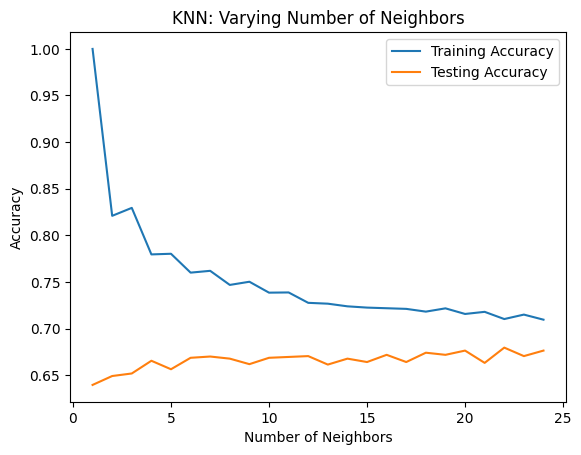

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24] 
 {np.int64(1): 0.9998863507216729, np.int64(2): 0.8208887373565178, np.int64(3): 0.829412433231049, np.int64(4): 0.7795204000454597, np.int64(5): 0.7802022957154222, np.int64(6): 0.7599727241732015, np.int64(7): 0.7619047619047619, np.int64(8): 0.7467894078872599, np.int64(9): 0.7501988862370724, np.int64(10): 0.7384930105693829, np.int64(11): 0.738720309126037, np.int64(12): 0.7275826798499829, np.int64(13): 0.7266734856233663, np.int64(14): 0.7238322536651892, np.int64(15): 0.7224684623252642, np.int64(16): 0.7217865666553017, np.int64(17): 0.7211046709853393, np.int64(18): 0.7181497897488351, np.int64(19): 0.7216729173769747, np.int64(20): 0.7156495056256392, np.int64(21): 0.7179224911921809, np.int64(22): 0.7101943402659393, np.int64(23): 0.7149676099556768, np.int64(24): 0.7095124445959768} 
 {np.int64(1): 0.6395454545454545, np.int64(2): 0.649090909090909, np.int64(3): 0.6518181818181819, np.int64(4): 0.66

In [106]:
neighbors = np.arange(1, 25)
train_accuracies = {}
test_accuracies = {}
for neighbor in neighbors:
  
	# Set up a KNN Classifier
	knn = KNeighborsClassifier(n_neighbors=neighbor).fit(X_train,y_train)
  
	# Fit the model
	knn.fit(X_train, y_train)
  
	# Compute accuracy
	train_accuracies[neighbor] = knn.score(X_train, y_train)
	test_accuracies[neighbor] = knn.score(X_test, y_test)


# PLOT MODEL COMPLEXITY
plt.title("KNN: Varying Number of Neighbors")

# Plot training accuracies
plt.plot(neighbors, train_accuracies.values(), label="Training Accuracy")

# Plot test accuracies
plt.plot(neighbors, test_accuracies.values(), label="Testing Accuracy")

plt.legend()
plt.xlabel("Number of Neighbors")
plt.ylabel("Accuracy")

# Display the plot
plt.show()
print(neighbors, '\n', train_accuracies, '\n', test_accuracies)


In [107]:
# Find the key corresponding to the maximum value
best_key = max(test_accuracies, key=test_accuracies.get)
best_value = test_accuracies[best_key]

print(f"K={best_key} is the best value for the hyperparameter 'n_neighbors', to maximize accuracy ")
print(f"Highest value: {best_value:.2f}")


K=22 is the best value for the hyperparameter 'n_neighbors', to maximize accuracy 
Highest value: 0.68


In [108]:
best_knn_params={
 'n_neighbors': 22}
Tuned_KNN=KNeighborsClassifier(**best_knn_params)
Tuned_KNN.fit(X_train,y_train)
KNN_predictionS=Tuned_KNN.predict(X_test)
y_proba_all_KNN = Tuned_KNN.predict_proba(X_test)
y_scores_KNN = y_proba_all_KNN[:, 1]

In [109]:
Accur_KNN11=accuracy_score(y_test,KNN_predictionS)
print('Accuracy:',f"{Accur_KNN11:.3f}")

F1_KNN1=f1_score(y_test,KNN_predictionS)
print('f1:' ,f"{F1_KNN1:.3f}")

Recall_knn1=recall_score(y_test,KNN_predictionS)
print('Recall:',f"{Recall_knn1:.3f}")

Prec_KNN1=precision_score(y_test,KNN_predictionS)
print('precicion:',f"{Prec_KNN1:.3f}")
Auc_knn1=roc_auc_score(y_test,y_scores_KNN)
print('Auc:',f"{Auc_knn1:.3f}")

print(confusion_matrix(y_test,KNN_predictionS))

Accuracy: 0.680
f1: 0.690
Recall: 0.597
precicion: 0.817
Auc: 0.750
[[711 176]
 [529 784]]


**RANDOMFOREST TUNE


In [110]:
# RANDOM FOREST TUNIN

param_grid_RF = {'n_estimators': range(10, 50, 10),
              'criterion' : ["gini", "entropy",'log_loss'],
               'max_depth' : [None, 5, 10, 20],
               'bootstrap' : [True, False],
               'min_samples_split' : [2,5,10,20],
               'min_samples_leaf' : [1,5,10,20],
               'max_features':['sqrt', 'log2',0.5,0.8],
               'class_weight': ['balanced',None],
               'ccp_alpha': [0.0, 0.0001, 0.001, 0.01, 0.1],
               'min_impurity_decrease': [0.0, 0.0001, 0.001, 0.01, 0.1]
            }

random_search_RF = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42), 
    param_distributions=param_grid_RF,
    n_iter=100,  # Number of parameter settings that are sampled
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42,error_score='raise' # Set a random state for reproducibility
)
random_search_RF.fit(X_train, y_train)

print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_RF.best_params_)


--- RandomizedSearchCV Best Parameters ---
{'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0001, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'log_loss', 'class_weight': None, 'ccp_alpha': 0.01, 'bootstrap': False}


In [111]:
best_rf_params={'n_estimators': 20, 'min_samples_split': 10, 'min_samples_leaf': 5, 'min_impurity_decrease': 0.0001, 'max_features': 'log2', 'max_depth': 10, 'criterion': 'log_loss', 'class_weight': None, 'ccp_alpha': 0.01, 'bootstrap': False}
Tuned_RF=RandomForestClassifier(**best_rf_params,random_state=42,n_jobs=-1)
Tuned_RF.fit(X_train,y_train)
rf_tuned_predictions=Tuned_RF.predict(X_test)
y_proba_all_RF = Tuned_RF.predict_proba(X_test)
y_scores_RF = y_proba_all_RF[:, 1]

In [112]:
accuracy_rf = accuracy_score(y_test, rf_tuned_predictions)
print('Accuracy:',f"{accuracy_rf:.3f}")
F1_SCORE_RF=f1_score(y_test,rf_tuned_predictions)
print('f1:',f"{F1_SCORE_RF:.3f}")

print(confusion_matrix(y_test,rf_tuned_predictions))

recall_rf=recall_score(y_test,rf_tuned_predictions)
print('Recall:',f"{recall_rf:.3f}")

prec_rf1= precision_score(y_test,rf_tuned_predictions)
print('Precicion:',f"{prec_rf1:.3f}")


auc_rf1=roc_auc_score(y_test,y_scores_RF)
print('AUC:',f"{auc_rf1:.3f}")

Accuracy: 0.677
f1: 0.639
[[861  26]
 [684 629]]
Recall: 0.479
Precicion: 0.960
AUC: 0.745


*LOG REGRESSION TUNE


In [113]:
param_grid_lg ={
        'penalty': ['l1', 'l2'],
        'solver': ['liblinear', 'saga'],
        'max_iter': [1000, 2000], 
        'C': [0.001, 0.01, 0.1, 1, 10, 100]
    }
   
   
grid_search_lg = GridSearchCV(LogisticRegression(solver='liblinear'),
    param_grid_lg,
    scoring='accuracy',
    cv=cv,                 # Use 5-fold cross-validation
    verbose=1,
    n_jobs=-1          # Use all available CPU cores
)
grid_search_lg.fit(X_train, y_train)
grid_search_lg.best_params_


Fitting 5 folds for each of 48 candidates, totalling 240 fits


{'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'liblinear'}

In [143]:
lg_best={'C': 0.01, 'max_iter': 1000, 'penalty': 'l2'}


Tuned_lg=LogisticRegression(**lg_best,random_state=42,solver='liblinear')
Tuned_lg.fit(X_train,y_train)
LG_tuned_predictions=Tuned_lg.predict(X_test)
y_proba_all_lg = Tuned_lg.predict_proba(X_test)
y_scores_lg = y_proba_all_lg[:, 1]


In [144]:
AC_log1=accuracy_score(y_test,LG_tuned_predictions)
print('accuracy:',f"{AC_log1:.3f}")
f1_log1=f1_score(y_test,LG_tuned_predictions)
print('f1:',f"{f1_log1:.3f}")
recalllog1=recall_score(y_test,LG_tuned_predictions)
print('recall:',f"{recalllog1:.3f}")
precicion_log1=precision_score(y_test,LG_tuned_predictions)
print('precicion:',f"{precicion_log1:.3f}")
auc_lo1=roc_auc_score(y_test,y_scores_lg)
print('auc:',f"{auc_lo1:.3f}")
print(confusion_matrix(y_test,LG_tuned_predictions))

accuracy: 0.659
f1: 0.704
recall: 0.680
precicion: 0.730
auc: 0.737
[[556 331]
 [420 893]]


****SVM TUNE

In [116]:
param_grid_SVC = {
    'C': [0.1, 1, 10],            
    'kernel': ['rbf', 'poly'],    
    'gamma': ['scale', 'auto']    
}
grid_SVC = GridSearchCV(
    SVC(random_state=42, probability=True), 
    param_grid_SVC, 
    cv=cv,                      
    n_jobs=-1,                 
    scoring='accuracy' ,error_score='raise' 
)
grid_SVC.fit(X_train, y_train)
grid_SVC.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [145]:
svm_best={'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

Tuned_svm=SVC(**svm_best,random_state=42,probability=True)
Tuned_svm.fit(X_train,y_train)
SVM_tuned_predictions=Tuned_svm.predict(X_test)
y_proba_all_svm1 = Tuned_svm.predict_proba(X_test)
y_scores_svm1 = y_proba_all_svm1[:, 1]

In [146]:
print("--- SVC BASELINE METRICS (Default Settings) ---")
Acc_sv1= accuracy_score(y_test, SVM_tuned_predictions)
print('Accuracy:',f"{Acc_sv1:.3f}")
f1_svm1= f1_score(y_test, SVM_tuned_predictions)
print('f1:',f"{f1_svm1:.3f}")

AUC_SVM1= roc_auc_score(y_test, y_scores_svm1)
print('AUC:',f"{AUC_SVM1:.3f}")


Recall_svm1= recall_score(y_test, SVM_tuned_predictions)
print('recall:',f"{Recall_svm1:.3f}")

Precicion_svm1=precision_score(y_test, SVM_tuned_predictions)
print('precicion:',f"{Precicion_svm1:.3f}")
print('Confusion Matrix:\n', confusion_matrix(y_test, SVM_tuned_predictions))

--- SVC BASELINE METRICS (Default Settings) ---
Accuracy: 0.678
f1: 0.639
AUC: 0.754
recall: 0.478
precicion: 0.963
Confusion Matrix:
 [[863  24]
 [685 628]]



***XGBOOST TUNE


In [119]:
param_grid_XG = {
        'n_estimators': [100, 200, 300],
        'max_depth': [3, 5, 7],
        'learning_rate': [0.01, 0.1, 0.2],
        'subsample': [0.7, 0.8, 1.0],
        'colsample_bytree': [0.7, 0.8, 1.0],
        'gamma':[0, 0.1, 0.2],
        'min_child_weight':[1, 3, 5, 7],
        'grow_policy':['depthwise','lossguide'],
        'scale_pos_weight': [1, 2, 3],
        'reg_lambda': [1, 5, 10],
        'reg_alpha': [0, 0.1, 0.5]
        }
random_search_XG = RandomizedSearchCV(
    estimator=XGBClassifier(random_state=42, eval_metric='logloss'), 
    param_distributions=param_grid_XG,
    n_iter=100,  
    cv=cv,
    scoring='accuracy',
    n_jobs=-1,
    random_state=42 
)
random_search_XG.fit(X_train, y_train)

print("--- RandomizedSearchCV Best Parameters ---")
print(random_search_XG.best_params_)
print("\n--- RandomizedSearchCV Best Score (Average CV Accuracy) ---")
print(f"{random_search_XG.best_score_:.4f}")

--- RandomizedSearchCV Best Parameters ---
{'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0.1, 'colsample_bytree': 1.0}

--- RandomizedSearchCV Best Score (Average CV Accuracy) ---
0.6864


In [120]:
xg_best={'subsample': 0.8, 'scale_pos_weight': 1, 'reg_lambda': 5, 'reg_alpha': 0.5, 'n_estimators': 300, 'min_child_weight': 5, 'max_depth': 3, 'learning_rate': 0.01, 'grow_policy': 'lossguide', 'gamma': 0.1, 'colsample_bytree': 1.0}
Tuned_xg=XGBClassifier(**xg_best,random_state=42,n_jobs=-1,eval_metric="logloss")
Tuned_xg.fit(X_train,y_train)
XG_tuned_predictions=Tuned_xg.predict(X_test)
y_proba_all = Tuned_xg.predict_proba(X_test)
y_scores = y_proba_all[:, 1]

In [121]:
xg_a1c=accuracy_score(y_test,XG_tuned_predictions)
print('accuracy:',f"{xg_a1c:.3f}")

f1_xg1=f1_score(y_test,XG_tuned_predictions)
print('f1:',f"{f1_xg1:.3f}")


Recall_xg1=recall_score(y_test,XG_tuned_predictions)
print('Recall:',f"{Recall_xg1:.3f}")

PREC_XG1=precision_score(y_test,XG_tuned_predictions)
print('precicion:',f"{PREC_XG1:.3f}")


AUC_XG1=roc_auc_score(y_test,XG_tuned_predictions)
print('AUC:',f"{AUC_XG1:.3f}")

print(confusion_matrix(y_test,XG_tuned_predictions))

accuracy: 0.680
f1: 0.643
Recall: 0.483
precicion: 0.961
AUC: 0.727
[[861  26]
 [679 634]]


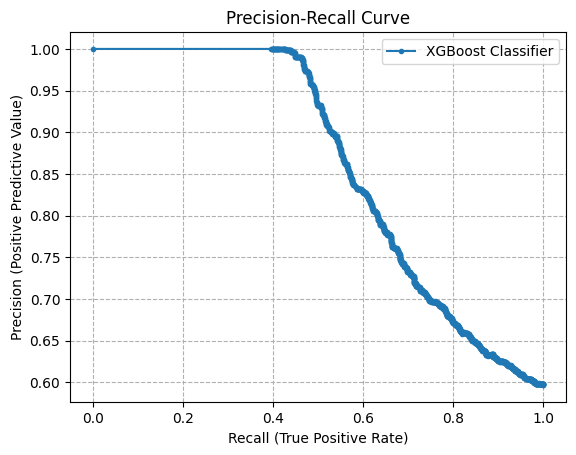

In [122]:
precision, recall, thresholds = precision_recall_curve( y_test,y_scores )
plt.plot(recall, precision, marker='.', label='XGBoost Classifier')
plt.xlabel('Recall (True Positive Rate)')
plt.ylabel('Precision (Positive Predictive Value)')
plt.title('Precision-Recall Curve')
plt.grid(True, linestyle='--')

plt.legend()



In [123]:
for i, item in enumerate(Tuned_xg.feature_importances_):
      # Use i and item to print out the feature importance of each column
    print("{0:s}: {1:.2f}".format(X_train.columns[i], item))

Discount_offered: 0.79
Weight_in_gms: 0.05
Discount_as_Ratio: 0.01
Value_Density: 0.08
Cost_of_the_Product: 0.02
Prior_purchases: 0.05


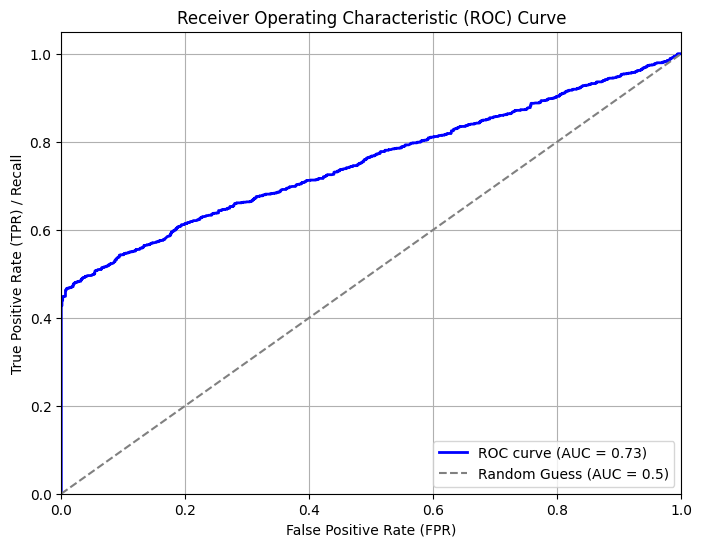

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label='ROC curve (AUC = 0.73)')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Random Guess (AUC = 0.5)')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR) / Recall')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

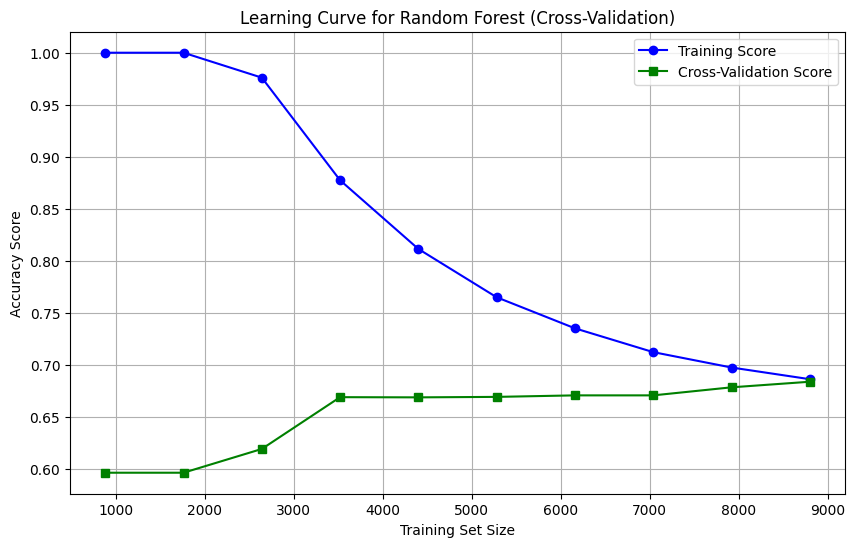

In [125]:
#learning curve for Random Forest
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    Tuned_RF, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for Random Forest (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

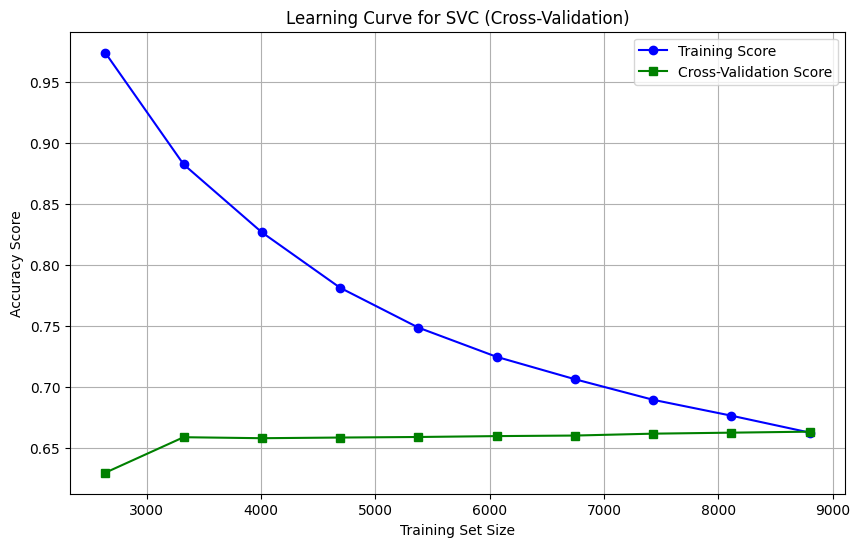

In [133]:
#learning curve for SVM
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
    Tuned_svm, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.3, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for SVC (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

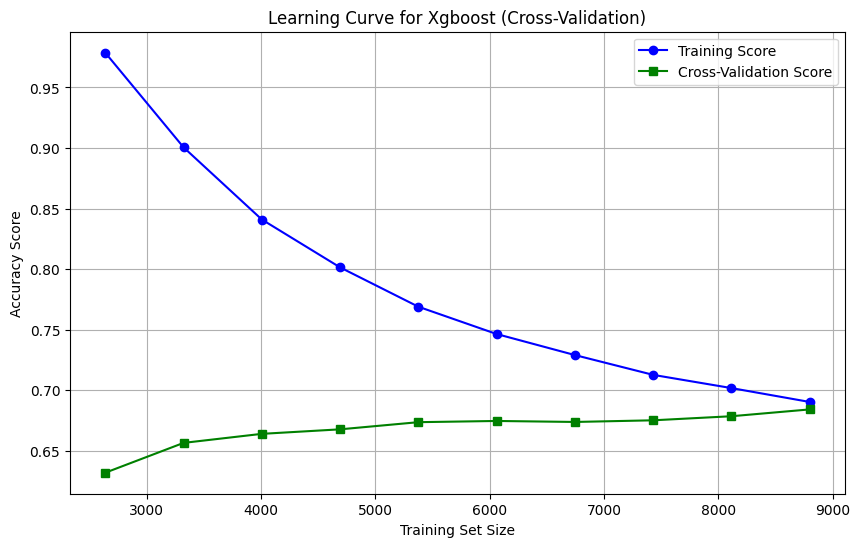

In [135]:
#learning curve for xgboost
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
   Tuned_xg, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.3, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for Xgboost (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

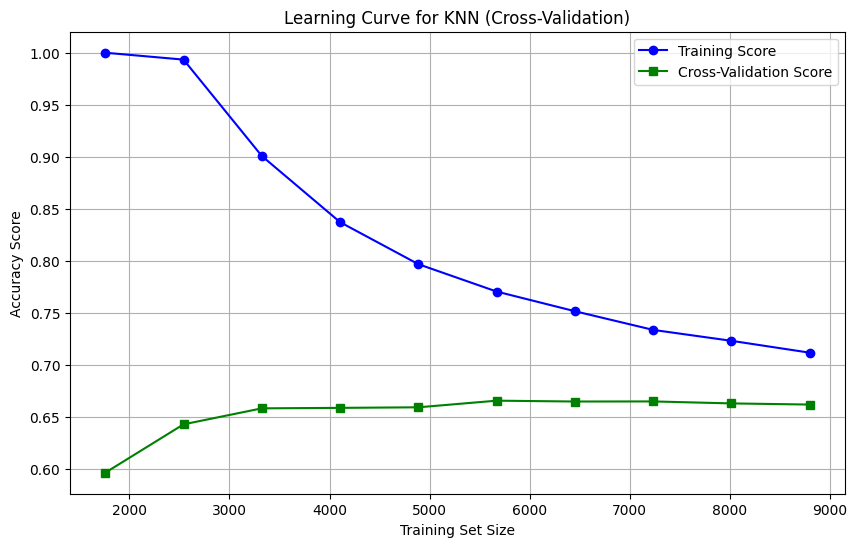

In [140]:
#learning curve for knn
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
   Tuned_KNN, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.2, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for KNN (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

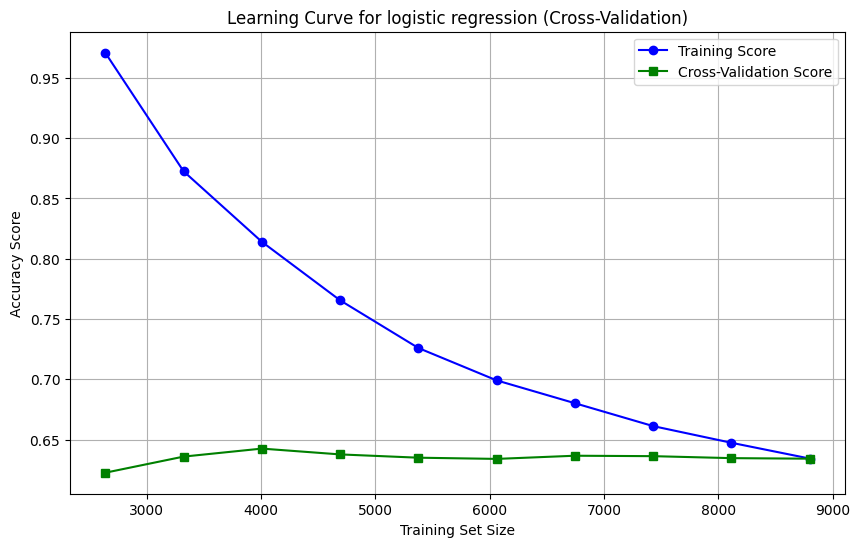

In [139]:
#learning curve for lg
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
   Tuned_lg, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.3, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)

test_mean = np.mean(test_scores, axis=1)



plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for logistic regression (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()

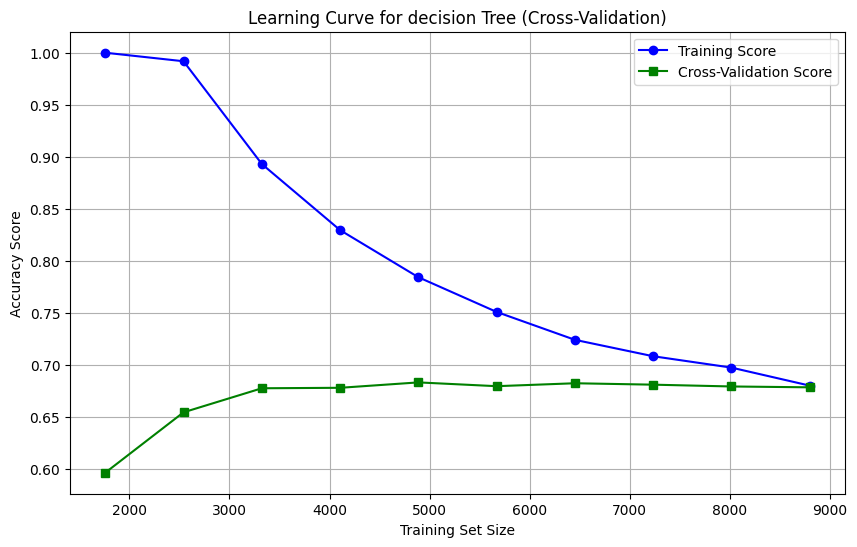

In [137]:
#learning curve for dec
from sklearn.model_selection import learning_curve

train_sizes, train_scores, test_scores = learning_curve(
   Dec_Tree_tuned, X, y, cv=cv, scoring='accuracy', n_jobs=-1, 
    train_sizes=np.linspace(0.2, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training Score', color='blue', marker='o')
plt.plot(train_sizes, test_mean, label='Cross-Validation Score', color='green', marker='s')


plt.title('Learning Curve for decision Tree (Cross-Validation)')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy Score')
plt.legend(loc='best')
plt.grid(True)
plt.show()